In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zut
import CombineColors as CC
from PIL import Image, ImageSequence, ImageFont, ImageDraw
from PIL.TiffTags import TAGS
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
import pandas as pd
from skimage.filters import threshold_otsu
import copy
from skimage.measure import label
from skimage import morphology as morph
import zut
import CombineColors as CC
from matplotlib.cm import get_cmap
import io
from ipywidgets import widgets
from IPython.display import display
from ipyevents import Event 

In [10]:
data = pickle.load(open('data_good.p', 'rb'))
cell_df = pickle.load(open('cell_df_good.p','rb'))

In [11]:


def findcellid(cellmask, x, y):
    return cellmask[x, y]


def uint(x):
    return (np.array(x)*255).astype('uint8')

def showcellloc(boundmask, cell_id):
    bound_all = np.where(data[fn]['mask']['bound']>0, 1, 0) 
    if cell_id > 0:
        bound_cur = np.where(data[fn]['mask']['bound']==cell_id, 1, 0) 
        Im = CC.CombineColor({'all':bound_all, 'cur':bound_cur}, ['w', 'r'],addlegend=False )
    else:
        Im = CC.CombineColor({'all':bound_all}, ['w'],addlegend=False )
    return Im

def Im2Bytes(Im):
    img_byte_arr = io.BytesIO()
    Im.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr

In [12]:

def cell_level_class(data, cell_df, fn, level, m = None, label = None,cmap='inferno'):
    cm = get_cmap(cmap)
    df = cell_df.loc[cell_df['Image']==fn, ['Cell',level ]]
    cellmask = data[fn]['mask']['cellmask']
    im = np.zeros((cellmask.shape[0], cellmask.shape[1], 3))
    legend_dict = {}

    if m:
        df[f'{m}_ave'] = cell_df.loc[cell_df['Image']==fn, f'{m}_ave']

        im_c = np.zeros_like(cellmask, dtype=float)
        for cell_id in df['Cell']:
            im_c[cellmask==cell_id] = df.loc[df['Cell']==cell_id, f'{m}_ave']/max(np.max(df[f'{m}_ave']), 0.00001)
    
        c_df = pd.DataFrame(im_c)
        c_df = c_df.stack().reset_index()

        legend_dict[f'{m}_low'] = tuple(uint(cm(0.35)[0:3]))
        legend_dict[f'{m}_high'] = tuple(uint(cm(0.85)[0:3]))

        for j in [0,1,2]:
            im[c_df.iloc[:,0], c_df.iloc[:,1], j] = cm(c_df.iloc[:,2])[:,j]
    im = uint(im)

    if label:
        boundcolor = (0, 255, 255)
        boundmask = data[fn]['mask']['bound']
        cell_toshow = df.loc[df[level]==label, 'Cell']
        if len(cell_toshow)>0:
            im_bound = np.any(np.dstack([boundmask == i for i in cell_toshow]), axis=2)
            for j in [0,1,2]:
                im[im_bound,j] = boundcolor[j]
        legend_dict[f'{level}={label}:{len(cell_toshow)}'] = boundcolor

    Im = Image.fromarray(im)
    Im = CC.add_legend(Im, legend_dict)
    # plt.figure(facecolor=(1,1,1), figsize=(7,7))
    # plt.imshow(Im)
    # plt.title('Cell values')
    # zut.axisoff()

In [31]:
def visualizecellclass(cell_df, data, fn, cell_id = 0):

    color_dict_c = {
        'other': 'grey',
        'Mel': 'cyan',
        'Mye?': 'deco',
        'Mye': 'green',
        'T': 'red',
        'Tpro': 'yellow',
        'CTL':'apricot',
        'T/Mye':'wine',
        'B': 'pink',
    }
    legend_d = color_dict_c.copy()
    classes = list(color_dict_c.keys())
    cellmask = data[fn]['mask']['cellmask']
    df = cell_df.loc[cell_df['Image']==fn,:]
    page_dict = {}
    for t in classes:
        # zut.report(t)
        cell_ids = df.loc[df['Class']==t, 'Cell']
        if len(cell_ids) > 0:
            im = np.any(np.dstack([cellmask==cell_id for cell_id in cell_ids]), axis=2) 
        else:
            im = np.zeros_like(cellmask)
        page_dict[t] = im
    
    if cell_id > 0:
        bound_cur = np.where(data[fn]['mask']['bound']==cell_id, 1, 0) 
        bound_cur = morph.dilation(bound_cur)
        page_dict['cur'] = bound_cur
        color_dict_c['cur'] = 'white'
    
    Im = CC.CombineColor(page_dict, color_dict_c, palette = {'grey':(79,79,79)}, addlegend=False)
    Im = CC.add_legend(Im, CC.color2rgb(legend_d))
    return Im

def cellclass_markcell(Im, data, fn, cell_id):
    if cell_id == 0:
        return Im
    else:
        im = np.array(Im)
        bound_cur = np.where(data[fn]['mask']['bound']==cell_id, 1, 0) 
        E = zut.M2E(bound_cur)
        x = E[:, 0]
        y = E[:, 1]
        for j in [0,1,2]:
            im[x, y, j] = 0
        bound_cur = morph.dilation(bound_cur) - bound_cur
        E = zut.M2E(bound_cur)
        x = E[:, 0]
        y = E[:, 1]
        for j in [0,1,2]:
            im[x, y, j] = 255
        return Image.fromarray(im)


In [32]:
fn_ls = list(data.keys())
w_fn = widgets.Dropdown(options=fn_ls, value='roi4')
fn = w_fn.value
# class_Ims = {fn:visualizecellclass(cell_df, data, fn, cell_id=0)}


w_im = widgets.Image(value=Im2Bytes(cellclass_markcell(class_Ims[w_fn.value], data, w_fn.value, cell_id=0)), format='png')
w_im.layout.max_width = '60%'
w_im.layout.height = 'auto'


im_events = Event()
im_events.source = w_im
im_events.watched_events = ['click']

# no_drag = Event(source=w_im, watched_events=['dragstart'], prevent_default_action = True)

coordinates = widgets.Label(f'Roi = {fn}. Click to investigate the cell.')

vbox = widgets.VBox([w_fn, w_im, coordinates])

def update_coords(event):
    cell_id = findcellid(data[w_fn.value]['mask']['cellmask'], event['dataY'], event['dataX'])
    coordinates.value = 'Clicked at ({}, {}). Roi = {}, Cell_id = {}.'.format(event['dataX'], event['dataY'], w_fn.value, cell_id)
    w_im.value = Im2Bytes(cellclass_markcell(class_Ims[w_fn.value], data, w_fn.value, cell_id=cell_id))

def update_fn(*args):
    fn = w_im.value
    if not fn in class_Ims.keys():
        coordinates.value = f'Plotting classification for {w_fn.value}...'
        class_Ims[fn] = visualizecellclass(cell_df, data, fn, cell_id=0)
    w_im.value = Im2Bytes(cellclass_markcell(class_Ims[w_fn.value], data, w_fn.value, cell_id=0))
    coordinates.value = f'Switched to {w_fn.value}.'
im_events.on_dom_event(update_coords)

display(vbox)


In [8]:
cell_df.columns

Index(['Image', 'Cell', 'B7-H4', 'CD11b', 'CD11c', 'CD14', 'CD15', 'CD19-CD20',
       'CD3', 'CD31', 'CD33', 'CD4', 'CD45', 'CD56', 'CD68', 'CD74', 'CD8a',
       'Collagen-I', 'DNA1', 'Epcam+E-Cadherin', 'HLA-ABC', 'HLA-DR', 'Ki67',
       'Melanoma', 'aSMA'],
      dtype='object')

In [27]:
cell_id = 1375
Im = class_Ims[fn]
bound_cur = np.where(data[fn]['mask']['bound']==cell_id, 1, 0) 
bound_cur = morph.dilation(bound_cur)
E = zut.M2E(bound_cur)
x = E[:, 0]
y = E[:, 1]
im = np.array(Im)
for j in [0,1,2]:
    im[x, y, j] = 255
Im_new = Image.fromarray(im)

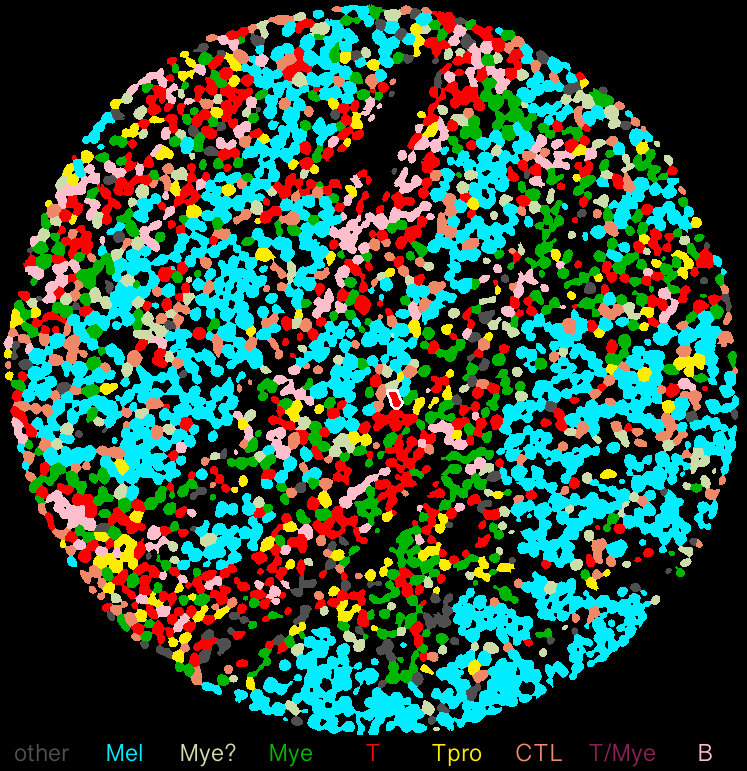

In [28]:
Im_new